## global imports and configurations

In [188]:
# imports
import pandas as pd
import os
import numpy as np
import math
import graphviz 

from copy import copy
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn import tree
from sklearn.model_selection import cross_val_score
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

In [136]:
# global configs
pd.set_option('display.max_columns', 30)

## load data and extract the complete data

In [137]:
df_data = pd.read_csv('../Project2-dataset/uci-datasets/hepatitis.data', header=None)
df_data_header = ['Class', 'AGE', 'SEX', 'STEROID', 'ANTIVIRALS', 'FATIGUE', 'MALAISE',
                  'ANOREXIA', 'LIVERBIG', 'LIVERFIRM', 'SPLEENPALPABLE', 'SPIDERS', 'ASCITES', 'VARICES', 'BILIRUBIN', 
                 'ALKPHOSPHATE', 'SGOT', 'ALBUMIN', 'PROTIME', 'HISTOLOGY']

In [138]:
print(df_data.shape)
print(df_data.describe(include='all'))
print(df_data.head())
print(len(df_data_header))

(155, 20)
                0           1           2    3           4    5    6    7   \
count   155.000000  155.000000  155.000000  155  155.000000  155  155  155   
unique         NaN         NaN         NaN    3         NaN    3    3    3   
top            NaN         NaN         NaN    2         NaN    1    2    2   
freq           NaN         NaN         NaN   78         NaN  100   93  122   
mean      1.793548   41.200000    1.103226  NaN    1.845161  NaN  NaN  NaN   
std       0.406070   12.565878    0.305240  NaN    0.362923  NaN  NaN  NaN   
min       1.000000    7.000000    1.000000  NaN    1.000000  NaN  NaN  NaN   
25%       2.000000   32.000000    1.000000  NaN    2.000000  NaN  NaN  NaN   
50%       2.000000   39.000000    1.000000  NaN    2.000000  NaN  NaN  NaN   
75%       2.000000   50.000000    1.000000  NaN    2.000000  NaN  NaN  NaN   
max       2.000000   78.000000    2.000000  NaN    2.000000  NaN  NaN  NaN   

         8    9    10   11   12   13    14   15   16 

In [139]:
complete_data_indice = df_data.apply(lambda row: row=='?', axis=1)
complete_data_indice = complete_data_indice.any(axis=1)
df_data_complete = df_data[-complete_data_indice]
df_data_incomplete = df_data[complete_data_indice]
print(df_data_complete.shape)
print(df_data_incomplete.shape)
print(df_data_complete.describe(include='all'))

(80, 20)
(75, 20)
               0         1          2    3          4    5    6    7    8   \
count   80.000000  80.00000  80.000000   80  80.000000   80   80   80   80   
unique        NaN       NaN        NaN    2        NaN    2    2    2    2   
top           NaN       NaN        NaN    2        NaN    1    2    2    2   
freq          NaN       NaN        NaN   42        NaN   52   49   68   67   
mean     1.837500  40.66250   1.137500  NaN   1.737500  NaN  NaN  NaN  NaN   
std      0.371236  11.28003   0.346547  NaN   0.442769  NaN  NaN  NaN  NaN   
min      1.000000  20.00000   1.000000  NaN   1.000000  NaN  NaN  NaN  NaN   
25%      2.000000  32.00000   1.000000  NaN   1.000000  NaN  NaN  NaN  NaN   
50%      2.000000  38.50000   1.000000  NaN   2.000000  NaN  NaN  NaN  NaN   
75%      2.000000  49.25000   1.000000  NaN   2.000000  NaN  NaN  NaN  NaN   
max      2.000000  72.00000   2.000000  NaN   2.000000  NaN  NaN  NaN  NaN   

         9    10   11   12   13    14   15   

## apply decision tree on the complete data by 10 fold cross-validation


In [140]:
def assess_model(data, random_state=0, cv=10):
    clf = tree.DecisionTreeClassifier(random_state=0)
    dt_train_X = data.drop(0, axis=1)
    dt_train_y = data.loc[:, 0]
    cv_results = cross_val_score(clf, dt_train_X, dt_train_y, cv=10)
    return np.mean(cv_results)

In [141]:
assess_model(df_data_complete)

0.79444444444444451

## analyse and fill missing data

In [142]:
# SEX: male, female
df_data[df_data[3] == '?']

0   1   2  3   4  5  6  7  8  9  10 11 12 13    14  15  16   17  18  19
3   2  31   1  ?   1  2  2  2  2  2  2  2  2  2  0.70  46  52  4.0  80   1

In [143]:
# delete data with too many missing columns
def remove_rows_with_little_info(target_data, missing_col_threshold=10, missing_value_rep='?'):
    for row_index, row_series in target_data.iterrows():
        row_missing_series = row_series[row_series==missing_value_rep]
        if row_missing_series.size >= missing_col_threshold:
            target_data = target_data.drop(row_index, axis=0)
            print('row:%d has been removed' % row_index)
    return target_data

# fill categorical missing value by knn
def fill_missing_data_by_knn(filling_cols, complete_data, target_data, missing_col_threshold=3, missing_value_rep='?'):
    knn = KNeighborsClassifier(n_neighbors=3)
    for row_index, row_series in target_data.iterrows():
        row_missing_series = row_series[row_series==missing_value_rep]
        if row_missing_series.size > 0 and row_missing_series.size <= missing_col_threshold:
            df_train_X = df_data_complete.drop(row_missing_series.index.values, axis=1)
            for missing_col in filling_cols:
                if missing_col in row_missing_series.index.values:
                    df_train_y = df_data_complete.iloc[:, missing_col]
                    knn.fit(df_train_X, df_train_y)
                    ss_test_X = row_series.drop(row_missing_series.index.values)
                    test_y = knn.predict(ss_test_X.values.reshape((1,-1)))
                    target_data.loc[row_index, missing_col] = test_y[0]
                    print('row:%d, col:%d has been filled by knn' % (row_index, missing_col) )
    return target_data

# fill categorical missing value by logistic regression
def fill_missing_data_by_lregression(filling_cols, complete_data, target_data,
                                     missing_col_threshold=(4, 9), missing_value_rep='?'):
    lr = LogisticRegression()
    for row_index, row_series in target_data.iterrows():
        row_missing_series = row_series[row_series==missing_value_rep]
        if row_missing_series.size >= missing_col_threshold[0] and row_missing_series.size <= missing_col_threshold[1]:
            df_train_X = df_data_complete.drop(row_missing_series.index.values, axis=1)
            for missing_col in filling_cols:
                if missing_col in row_missing_series.index.values:
                    df_train_y = df_data_complete.iloc[:, missing_col]
                    lr.fit(df_train_X, df_train_y)
                    ss_test_X = row_series.drop(row_missing_series.index.values)
                    test_y = lr.predict(ss_test_X.values.reshape((1,-1)))
                    target_data.loc[row_index, missing_col] = test_y[0]
                    print('row:%d, col:%d has been filled by logistic regression' % (row_index, missing_col) )
    return target_data

# fill continous missing value by linear regression
def fill_missing_data_by_linearregression(filling_cols, complete_data, target_data,
                                     missing_col_threshold=(1, 9), missing_value_rep='?'):
    lr = LinearRegression()
    for row_index, row_series in target_data.iterrows():
        row_missing_series = row_series[row_series==missing_value_rep]
        if row_missing_series.size >= missing_col_threshold[0] and row_missing_series.size <= missing_col_threshold[1]:
            df_train_X = df_data_complete.drop(row_missing_series.index.values, axis=1)
            for missing_col in filling_cols:
                if missing_col in row_missing_series.index.values:
                    df_train_y = df_data_complete.iloc[:, missing_col]
                    lr.fit(df_train_X, df_train_y)
                    ss_test_X = row_series.drop(row_missing_series.index.values)
                    test_y = lr.predict(ss_test_X.values.reshape((1,-1)))
                    target_data.loc[row_index, missing_col] = test_y[0]
                    print('row:%d, col:%d has been filled by linear regression' % (row_index, missing_col) )
    return target_data

In [144]:
# using hot deck imputation idea and Machine learning method KNN
df_data[df_data[3] == '?']

0   1   2  3   4  5  6  7  8  9  10 11 12 13    14  15  16   17  18  19
3   2  31   1  ?   1  2  2  2  2  2  2  2  2  2  0.70  46  52  4.0  80   1

In [145]:
# STEROID: no, yes
df_data[df_data[5] == '?']

0   1   2  3   4  5  6  7  8  9  10 11 12 13 14 15 16 17 18  19
56   2  34   1  1   2  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?   1

In [146]:
# ANTIVIRALS: no, yes
df_data[df_data[6] == '?']

0   1   2  3   4  5  6  7  8  9  10 11 12 13 14 15 16 17 18  19
56   2  34   1  1   2  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?   1

In [147]:
# FATIGUE: no, yes
df_data[df_data[7] == '?']

0   1   2  3   4  5  6  7  8  9  10 11 12 13 14 15 16 17 18  19
56   2  34   1  1   2  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?   1

In [148]:
# delete this row with too many missing columns 
df_data = remove_rows_with_little_info(df_data)
df_data.shape

row:56 has been removed


(154, 20)

In [149]:
# MALAISE: no, yes
df_data[df_data[8] == '?']

0   1   2  3   4  5  6  7  8  9  10 11 12 13    14   15   16   17  18  19
31    1  62   1  1   2  1  1  2  ?  ?  2  2  2  2  1.00    ?   60    ?   ?   1
41    2  23   1  2   2  2  2  2  ?  ?  ?  ?  ?  ?  4.60   56   16  4.6   ?   1
72    2  51   1  2   2  1  1  1  ?  ?  ?  ?  ?  ?  0.90   76  271  4.4   ?   1
92    2  33   1  2   2  2  2  2  ?  ?  2  2  2  2  1.00    ?   60  4.0   ?   2
106   1  35   1  1   2  1  2  2  ?  ?  1  1  1  2  1.50  138   58  2.6   ?   2
118   1  61   1  1   2  1  1  2  ?  ?  2  1  2  2     ?    ?    ?    ?   ?   2
126   2  28   1  2   2  1  1  1  ?  ?  2  1  1  2  1.00    ?   20  4.0   ?   2
141   1  54   1  1   2  1  1  2  ?  ?  1  2  1  2  3.90  120   28  3.5  43   2
147   1  70   1  1   2  1  1  1  ?  ?  ?  ?  ?  ?  1.70  109  528  2.8  35   2

In [150]:
# ANOREXIA: no, yes
df_data[df_data[9] == '?']

0   1   2  3   4  5  6  7  8  9  10 11 12 13    14   15   16   17  18  19
31    1  62   1  1   2  1  1  2  ?  ?  2  2  2  2  1.00    ?   60    ?   ?   1
41    2  23   1  2   2  2  2  2  ?  ?  ?  ?  ?  ?  4.60   56   16  4.6   ?   1
72    2  51   1  2   2  1  1  1  ?  ?  ?  ?  ?  ?  0.90   76  271  4.4   ?   1
92    2  33   1  2   2  2  2  2  ?  ?  2  2  2  2  1.00    ?   60  4.0   ?   2
106   1  35   1  1   2  1  2  2  ?  ?  1  1  1  2  1.50  138   58  2.6   ?   2
118   1  61   1  1   2  1  1  2  ?  ?  2  1  2  2     ?    ?    ?    ?   ?   2
126   2  28   1  2   2  1  1  1  ?  ?  2  1  1  2  1.00    ?   20  4.0   ?   2
141   1  54   1  1   2  1  1  2  ?  ?  1  2  1  2  3.90  120   28  3.5  43   2
147   1  70   1  1   2  1  1  1  ?  ?  ?  ?  ?  ?  1.70  109  528  2.8  35   2
148   2  20   1  1   2  2  2  2  2  ?  2  2  2  2  0.90   89  152  4.0   ?   2

In [151]:
# LIVER BIG: no, yes
df_data[df_data[10] == '?']

0   1   2  3   4  5  6  7  8  9  10 11 12 13    14   15   16   17  18  19
41    2  23   1  2   2  2  2  2  ?  ?  ?  ?  ?  ?  4.60   56   16  4.6   ?   1
72    2  51   1  2   2  1  1  1  ?  ?  ?  ?  ?  ?  0.90   76  271  4.4   ?   1
83    2  67   2  1   2  1  1  2  2  2  ?  ?  ?  ?  1.50  179   69  2.9   ?   1
147   1  70   1  1   2  1  1  1  ?  ?  ?  ?  ?  ?  1.70  109  528  2.8  35   2

In [152]:
# LIVER FIRM: no, yes
df_data[df_data[11] == '?']

0   1   2  3   4  5  6  7  8  9  10 11 12 13    14   15   16   17  18  19
41    2  23   1  2   2  2  2  2  ?  ?  ?  ?  ?  ?  4.60   56   16  4.6   ?   1
72    2  51   1  2   2  1  1  1  ?  ?  ?  ?  ?  ?  0.90   76  271  4.4   ?   1
83    2  67   2  1   2  1  1  2  2  2  ?  ?  ?  ?  1.50  179   69  2.9   ?   1
147   1  70   1  1   2  1  1  1  ?  ?  ?  ?  ?  ?  1.70  109  528  2.8  35   2

In [153]:
# SPLEEN PALPABLE: no, yes
df_data[df_data[12] == '?']

0   1   2  3   4  5  6  7  8  9  10 11 12 13    14   15   16   17  18  19
41    2  23   1  2   2  2  2  2  ?  ?  ?  ?  ?  ?  4.60   56   16  4.6   ?   1
72    2  51   1  2   2  1  1  1  ?  ?  ?  ?  ?  ?  0.90   76  271  4.4   ?   1
83    2  67   2  1   2  1  1  2  2  2  ?  ?  ?  ?  1.50  179   69  2.9   ?   1
147   1  70   1  1   2  1  1  1  ?  ?  ?  ?  ?  ?  1.70  109  528  2.8  35   2

In [154]:
# SPIDERS: no, yes
df_data[df_data[13] == '?']

0   1   2  3   4  5  6  7  8  9  10 11 12 13    14   15   16   17  18  19
41    2  23   1  2   2  2  2  2  ?  ?  ?  ?  ?  ?  4.60   56   16  4.6   ?   1
72    2  51   1  2   2  1  1  1  ?  ?  ?  ?  ?  ?  0.90   76  271  4.4   ?   1
83    2  67   2  1   2  1  1  2  2  2  ?  ?  ?  ?  1.50  179   69  2.9   ?   1
147   1  70   1  1   2  1  1  1  ?  ?  ?  ?  ?  ?  1.70  109  528  2.8  35   2

In [155]:
# ASCITES: no, yes
df_data[df_data[14] == '?']

0   1   2  3   4  5  6  7  8  9  10 11 12 13 14 15  16 17 18  19
6     1  51   1  1   2  1  2  1  2  2  1  1  2  2  ?  ?   ?  ?  ?   1
14    2  47   1  1   1  2  2  2  2  2  2  2  2  2  ?  ?  60  ?  ?   1
44    2  34   1  2   2  2  2  2  2  2  2  2  2  2  ?  ?  86  ?  ?   1
99    2  60   1  1   2  1  2  2  1  1  1  1  2  2  ?  ?  40  ?  ?   2
118   1  61   1  1   2  1  1  2  ?  ?  2  1  2  2  ?  ?   ?  ?  ?   2

In [156]:
# VARICES: no, yes
df_data[df_data[15] == '?']

0   1   2  3   4  5  6  7  8  9  10 11 12 13    14 15   16   17  18  19
4     2  34   1  2   2  2  2  2  2  2  2  2  2  2  1.00  ?  200  4.0   ?   1
6     1  51   1  1   2  1  2  1  2  2  1  1  2  2     ?  ?    ?    ?   ?   1
7     2  23   1  2   2  2  2  2  2  2  2  2  2  2  1.00  ?    ?    ?   ?   1
8     2  39   1  2   2  1  2  2  2  1  2  2  2  2  0.70  ?   48  4.4   ?   1
9     2  30   1  2   2  2  2  2  2  2  2  2  2  2  1.00  ?  120  3.9   ?   1
14    2  47   1  1   1  2  2  2  2  2  2  2  2  2     ?  ?   60    ?   ?   1
31    1  62   1  1   2  1  1  2  ?  ?  2  2  2  2  1.00  ?   60    ?   ?   1
44    2  34   1  2   2  2  2  2  2  2  2  2  2  2     ?  ?   86    ?   ?   1
65    2  27   1  2   2  2  2  2  2  2  2  2  2  2  0.80  ?   38  4.2   ?   1
67    1  57   1  2   2  1  1  1  2  2  2  1  1  2  4.10  ?   48  2.6  73   1
73    2  36   1  1   2  1  1  1  2  1  2  2  2  2  1.00  ?   45  4.0  57   1
80    2  23   1  2   2  1  1  1  2  2  2  2  2  2  0.80  ?   14  4.8   ?   1
91    1  42   1  1   2  1  1  1  2  2  1  1  2  1  4.60  ?   55  3.3   ?   2
92    2  33   1  2   2  2  2  2  ?  ?  2  2  2  2  1.00  ?   60  4.0   ?   2
93    2  52   1  1   2  2  2  2  2  2  2  2  2  2  1.50  ?   69  2.9   ?   2
99    2  60   1  1   2  1  2  2  1  1  1  1  2  2     ?  ?   40    ?   ?   2
101   2  22   1  2   2  2  2  2  2  2  2  2  2  2  0.70  ?   24    ?   ?   2
105   2  25   1  2   2  2  2  2  2  2  2  2  2  2  0.60  ?   34  6.4   ?   2
107   2  45   1  1   2  1  1  1  2  2  2  2  2  2  2.30  ?  648    ?   ?   2
116   2  24   1  1   2  1  2  2  2  2  2  2  2  2  1.00  ?   34  4.1   ?   2
118   1  61   1  1   2  1  1  2  ?  ?  2  1  2  2     ?  ?    ?    ?   ?   2
123   2  37   1  1   2  1  2  2  2  2  2  1  2  2  0.90  ?  231  4.3   ?   2
126   2  28   1  2   2  1  1  1  ?  ?  2  1  1  2  1.00  ?   20  4.0   ?   2
131   1  31   1  1   2  1  1  1  2  2  1  2  2  2  8.00  ?  101  2.2   ?   2
136   2  51   1  2   2  2  2  2  1  1  2  1  2  2  0.80  ?   33  4.5   ?   2
142   2  51   1  2   2  1  2  2  2  1  1  1  2  1  1.00  ?   20  3.0  63   2
144   1  45   1  2   2  1  1  1  2  2  2  1  1  2  1.90  ?  114  2.4   ?   2
150   1  46   1  2   2  1  1  1  2  2  2  1  1  1  7.60  ?  242  3.3  50   2

In [157]:
# fix categorial rows with no more than 3 missing columns with knn
filling_cols = list(range(16))
df_data = fill_missing_data_by_knn(filling_cols=filling_cols, complete_data=df_data_complete, target_data=df_data)

row:3, col:3 has been filled by knn
row:4, col:15 has been filled by knn
row:8, col:15 has been filled by knn
row:9, col:15 has been filled by knn
row:65, col:15 has been filled by knn
row:67, col:15 has been filled by knn
row:73, col:15 has been filled by knn
row:80, col:15 has been filled by knn
row:91, col:15 has been filled by knn
row:93, col:15 has been filled by knn
row:101, col:15 has been filled by knn
row:105, col:15 has been filled by knn
row:106, col:8 has been filled by knn
row:106, col:9 has been filled by knn
row:107, col:15 has been filled by knn
row:116, col:15 has been filled by knn
row:123, col:15 has been filled by knn
row:131, col:15 has been filled by knn
row:136, col:15 has been filled by knn
row:141, col:8 has been filled by knn
row:141, col:9 has been filled by knn
row:142, col:15 has been filled by knn
row:144, col:15 has been filled by knn
row:148, col:9 has been filled by knn
row:150, col:15 has been filled by knn


In [158]:
# fix categorical rows with more than 3 and less than 10 missing columns 
df_data = fill_missing_data_by_lregression(filling_cols=filling_cols, complete_data=df_data_complete, target_data=df_data)

row:6, col:14 has been filled by logistic regression
row:6, col:15 has been filled by logistic regression
row:7, col:15 has been filled by logistic regression
row:14, col:14 has been filled by logistic regression
row:14, col:15 has been filled by logistic regression
row:31, col:8 has been filled by logistic regression
row:31, col:9 has been filled by logistic regression
row:31, col:15 has been filled by logistic regression
row:41, col:8 has been filled by logistic regression
row:41, col:9 has been filled by logistic regression
row:41, col:10 has been filled by logistic regression
row:41, col:11 has been filled by logistic regression
row:41, col:12 has been filled by logistic regression
row:41, col:13 has been filled by logistic regression
row:44, col:14 has been filled by logistic regression
row:44, col:15 has been filled by logistic regression
row:72, col:8 has been filled by logistic regression
row:72, col:9 has been filled by logistic regression
row:72, col:10 has been filled by log

In [159]:
# BILIRUBIN: 0.39, 0.80, 1.20, 2.00, 3.00, 4.00
df_data[df_data[16] == '?']

0   1   2  3   4  5  6  7  8  9  10 11 12 13    14   15 16 17 18  19
6     1  51   1  1   2  1  2  1  2  2  1  1  2  2  0.70   85  ?  ?  ?   1
7     2  23   1  2   2  2  2  2  2  2  2  2  2  2  1.00   95  ?  ?  ?   1
118   1  61   1  1   2  1  1  2  2  1  2  1  2  2  1.00  107  ?  ?  ?   2

In [160]:
# ALK PHOSPHATE: 33, 80, 120, 160, 200, 250
df_data[df_data[17] == '?']

0   1   2  3   4  5  6  7  8  9  10 11 12 13    14   15   16 17  18  19
6     1  51   1  1   2  1  2  1  2  2  1  1  2  2  0.70   85    ?  ?   ?   1
7     2  23   1  2   2  2  2  2  2  2  2  2  2  2  1.00   95    ?  ?   ?   1
14    2  47   1  1   1  2  2  2  2  2  2  2  2  2  1.00   85   60  ?   ?   1
31    1  62   1  1   2  1  1  2  2  1  2  2  2  2  1.00   78   60  ?   ?   1
44    2  34   1  2   2  2  2  2  2  2  2  2  2  2  0.70   85   86  ?   ?   1
55    2  37   1  1   2  1  1  1  2  2  2  2  2  2  0.80   92   59  ?   ?   1
59    2  45   2  1   2  1  1  2  2  2  1  2  2  2  1.00   85   75  ?   ?   1
71    1  34   1  1   2  1  1  2  1  1  2  1  2  2  2.80  127  182  ?   ?   1
86    1  44   1  1   2  1  1  2  2  2  1  2  2  1  0.90  135   55  ?  41   2
99    2  60   1  1   2  1  2  2  1  1  1  1  2  2  1.00   85   40  ?   ?   2
101   2  22   1  2   2  2  2  2  2  2  2  2  2  2  0.70  135   24  ?   ?   2
107   2  45   1  1   2  1  1  1  2  2  2  2  2  2  2.30  191  648  ?   ?   2
115   2  69   2  2   2  1  2  2  2  2  2  2  2  2  3.20  119  136  ?   ?   2
118   1  61   1  1   2  1  1  2  2  1  2  1  2  2  1.00  107    ?  ?   ?   2
122   2  42   1  2   2  2  2  2  2  2  1  2  2  2  1.50   85   40  ?   ?   2

In [161]:
# SGOT: 13, 100, 200, 300, 400, 500, 
df_data[df_data[18] == '?']

0   1   2  3   4  5  6  7  8  9  10 11 12 13    14   15   16   17 18  19
0     2  30   2  1   2  2  2  2  1  2  2  2  2  2  1.00   85   18  4.0  ?   1
1     2  50   1  1   2  1  2  2  1  2  2  2  2  2  0.90  135   42  3.5  ?   1
2     2  78   1  2   2  1  2  2  2  2  2  2  2  2  0.70   96   32  4.0  ?   1
4     2  34   1  2   2  2  2  2  2  2  2  2  2  2  1.00  181  200  4.0  ?   1
6     1  51   1  1   2  1  2  1  2  2  1  1  2  2  0.70   85    ?    ?  ?   1
7     2  23   1  2   2  2  2  2  2  2  2  2  2  2  1.00   95    ?    ?  ?   1
8     2  39   1  2   2  1  2  2  2  1  2  2  2  2  0.70  164   48  4.4  ?   1
9     2  30   1  2   2  2  2  2  2  2  2  2  2  2  1.00  147  120  3.9  ?   1
14    2  47   1  1   1  2  2  2  2  2  2  2  2  2  1.00   85   60    ?  ?   1
16    2  66   1  2   2  1  2  2  2  2  2  2  2  2  1.20  102   53  4.3  ?   1
26    2  49   1  1   1  1  1  1  2  1  2  1  2  2  0.60   85   48  3.7  ?   1
31    1  62   1  1   2  1  1  2  2  1  2  2  2  2  1.00   78   60    ?  ?   1
35    1  37   1  2   2  1  2  2  2  2  2  1  2  2  0.60   67   28  4.2  ?   1
37    2  20   2  1   2  1  1  1  1  1  1  1  2  2  2.30  150   68  3.9  ?   1
41    2  23   1  2   2  2  2  2  2  2  2  2  2  1  4.60   56   16  4.6  ?   1
44    2  34   1  2   2  2  2  2  2  2  2  2  2  2  0.70   85   86    ?  ?   1
45    2  28   1  2   2  1  1  2  2  2  2  2  2  2  0.70   74  110  4.4  ?   1
46    2  37   1  1   2  2  2  2  2  1  2  1  2  2  0.60   80   80  3.8  ?   1
50    2  39   1  1   2  2  2  2  2  2  2  2  2  2  0.90   85   60  4.0  ?   1
51    2  39   1  2   2  2  2  2  2  2  2  2  2  2  1.00   85   20  4.0  ?   1
55    2  37   1  1   2  1  1  1  2  2  2  2  2  2  0.80   92   59    ?  ?   1
59    2  45   2  1   2  1  1  2  2  2  1  2  2  2  1.00   85   75    ?  ?   1
65    2  27   1  2   2  2  2  2  2  2  2  2  2  2  0.80  100   38  4.2  ?   1
66    2  56   1  1   2  2  2  2  2  2  2  2  2  2  0.70   62   33  3.0  ?   1
69    2  44   1  1   2  1  1  2  2  2  2  2  2  2  1.60   68   68  3.7  ?   1
70    2  24   1  2   2  2  2  2  2  2  2  2  2  2  0.80   82   39  4.3  ?   1
71    1  34   1  1   2  1  1  2  1  1  2  1  2  2  2.80  127  182    ?  ?   1
72    2  51   1  2   2  1  1  1  2  1  2  2  2  2  0.90   76  271  4.4  ?   1
74    2  50   1  2   2  2  2  2  2  2  2  2  2  2  1.50  100  100  5.3  ?   1
76    1  58   1  2   2  1  2  2  1  1  1  1  2  2  2.00  167  242  3.3  ?   1
..   ..  ..  .. ..  .. .. .. .. .. .. .. .. .. ..   ...  ...  ...  ... ..  ..
92    2  33   1  2   2  2  2  2  2  2  2  2  2  2  1.00   85   60  4.0  ?   2
93    2  52   1  1   2  2  2  2  2  2  2  2  2  2  1.50   85   69  2.9  ?   2
97    2  44   1  1   2  1  1  2  1  1  2  1  2  2  3.00  114   65  3.5  ?   2
99    2  60   1  1   2  1  2  2  1  1  1  1  2  2  1.00   85   40    ?  ?   2
101   2  22   1  2   2  2  2  2  2  2  2  2  2  2  0.70  135   24    ?  ?   2
105   2  25   1  2   2  2  2  2  2  2  2  2  2  2  0.60  100   34  6.4  ?   2
106   1  35   1  1   2  1  2  2  2  2  1  1  1  2  1.50  138   58  2.6  ?   2
107   2  45   1  1   2  1  1  1  2  2  2  2  2  2  2.30  191  648    ?  ?   2
110   2   7   1  2   2  2  2  2  2  1  1  2  2  2  0.70  256   25  4.2  ?   2
112   2  52   1  1   2  1  2  2  2  2  2  2  2  2  1.00   85   30  4.0  ?   2
113   2  45   1  1   2  1  2  2  2  1  1  2  2  2  1.20   81   65  3.0  ?   1
114   2  36   1  1   2  2  2  2  2  2  2  2  2  2  1.10  141   75  3.3  ?   2
115   2  69   2  2   2  1  2  2  2  2  2  2  2  2  3.20  119  136    ?  ?   2
116   2  24   1  1   2  1  2  2  2  2  2  2  2  2  1.00  100   34  4.1  ?   2
118   1  61   1  1   2  1  1  2  2  1  2  1  2  2  1.00  107    ?    ?  ?   2
119   2  54   1  2   2  1  2  2  1  1  2  2  2  2  3.20   85   28  3.8  ?   2
120   1  56   1  1   2  1  1  1  1  1  2  1  2  2  2.90   90  153  4.0  ?   2
122   2  42   1  2   2  2  2  2  2  2  1  2  2  2  1.50   85   40    ?  ?   2
123   2  37   1  1   2  1  2  2  2  2  2  1  2  2  0.90  155  231  4.3  ?   2
126   2  28   1  2   2  1  

In [162]:
# fix continous data by linear regression
filling_cols = list(range(15, 19))
df_data = fill_missing_data_by_linearregression(filling_cols=filling_cols, complete_data=df_data_complete, target_data=df_data)

row:0, col:18 has been filled by linear regression
row:1, col:18 has been filled by linear regression
row:2, col:18 has been filled by linear regression
row:4, col:18 has been filled by linear regression
row:6, col:16 has been filled by linear regression
row:6, col:17 has been filled by linear regression
row:6, col:18 has been filled by linear regression
row:7, col:16 has been filled by linear regression
row:7, col:17 has been filled by linear regression
row:7, col:18 has been filled by linear regression
row:8, col:18 has been filled by linear regression
row:9, col:18 has been filled by linear regression
row:14, col:17 has been filled by linear regression
row:14, col:18 has been filled by linear regression
row:16, col:18 has been filled by linear regression
row:26, col:18 has been filled by linear regression
row:31, col:17 has been filled by linear regression
row:31, col:18 has been filled by linear regression
row:35, col:18 has been filled by linear regression
row:37, col:18 has been 

## apply decision tree on the filled data by 10 fold cv

In [163]:
df_data.to_csv(path_or_buf='hepatitis_fm.data', header=df_data_header, index=False)
assess_model(df_data)

0.81215686274509802

## analyse and descretise continous data 

In [164]:
def convert_string_float(df_data, cols):
    for i in cols:
        df_data[i] = df_data[i].astype(float)
    return df_data
continous_cols = list(range(14, 19))
df_data = convert_string_float(df_data, continous_cols)
# backup filled data
df_data_backup = copy(df_data)

In [165]:
def calculate_entropy(df_data, class_colum=0, class_labels=[1,2]):
    class_series = df_data[class_colum]
    total_number = class_series.size
    entropy = 0
    if total_number == 0:
        return 1
    for label in class_labels:
        p_c = sum(class_series == label) / total_number
        if p_c != 0:
            entropy -= p_c * math.log2(p_c)
    return entropy

def calculate_net_entropy(df_data, split_point, split_column, class_colum=0, class_labels=[1,2]):
    df_data_s1 = df_data.loc[df_data[split_column] < split_point]
    df_data_s2 = df_data.loc[df_data[split_column] >= split_point]
    entropy_s1 = calculate_entropy(df_data_s1)
    entropy_s2 = calculate_entropy(df_data_s2)
    net_entropy = df_data_s1.shape[0]/df_data.shape[0] * entropy_s1 + df_data_s2.shape[0]/df_data.shape[0] * entropy_s2
    return net_entropy

def search_split_point(df_data, split_points, split_column, class_colum=0, class_labels=[1,2], debug=True):
    current_max_gain = 0
    current_max_point = split_points[0]
    data_entropy = calculate_entropy(df_data)
    for point in split_points:
        net_entropy = calculate_net_entropy(df_data, point, split_column)
        new_info_gain = data_entropy - net_entropy
        if debug:
            print('net entropy:%f, data entropy:%f' % (net_entropy, data_entropy))
            print('current point:%f, current info gain:%f' % (point, new_info_gain))
        if new_info_gain > current_max_gain:
            current_max_point = point
            current_max_gain = new_info_gain
    if debug:
        if current_max_gain == 0:
            print('zero gain point found - point:%f, info-gain:%f' % (current_max_point, current_max_gain))
        else:
            print('split point found - point:%f, info-gain:%f' % (current_max_point, current_max_gain))
    return (current_max_point, current_max_gain)

def get_all_split_points(data, split_points, split_column, step_num, class_colum=0, class_labels=[1,2]):
    return_spoint_points = []
    cloned_data = copy(data)
    if step_num > 0:
        point, gain = search_split_point(cloned_data, split_points, split_column, class_colum, class_labels)
        if gain == 0:
            return return_spoint_points
        else:
            return_spoint_points = np.append(return_spoint_points, point)
            sub_split_points = [ split_points[split_points<point], split_points[split_points>=point] ]
            sub_data = [ cloned_data[cloned_data[split_column]<point], cloned_data[cloned_data[split_column]>=point] ]
            new_step_num = step_num - 1
            for i in range(len(sub_data)):
                if len(sub_split_points[i]) > 0:
                    sub_points = get_all_split_points(sub_data[i], sub_split_points[i], split_column, new_step_num, class_colum, class_labels)
                    return_spoint_points = np.append(return_spoint_points, sub_points)
    return return_spoint_points

def discretise_data(data, split_num, split_column, step_num, class_colum=0, class_labels=[1,2], unique_threshold=10):
    cloned_data = copy(data)
    if pd.Series.unique(cloned_data[split_column]).size > unique_threshold:
        split_points = np.linspace(cloned_data[split_column].min(), cloned_data[split_column].max(), split_num+1, False)
        split_points = np.delete(split_points, 0)
        split_points = get_all_split_points(cloned_data, split_points, split_column, step_num, class_colum, class_labels)
        split_points = np.sort(split_points)
        print(split_points)
        cloned_colum_data = copy(cloned_data[split_column])
        for i in range(len(split_points)):
            if i==0: 
                cloned_data.loc[cloned_colum_data < split_points[i], split_column] = i+1
            else:
                cloned_data.loc[np.logical_and(cloned_colum_data >= split_points[i-1], cloned_colum_data < split_points[i]), split_column ] = i+1
        cloned_data.loc[cloned_colum_data >= split_points[split_points.size-1], split_column] = split_points.size
    return cloned_data

In [166]:
def plot_hist_column(col, df_data=df_data):
    print(df_data[col].describe())
    plt.figure()
    plt.hist(df_data[col])
    plt.show()

count    154.000000
mean      41.246753
std       12.593344
min        7.000000
25%       32.000000
50%       39.000000
75%       50.000000
max       78.000000
Name: 1, dtype: float64


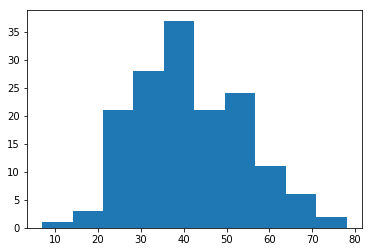

In [167]:
plot_hist_column(1, df_data)

net entropy:0.735051, data entropy:0.737241
current point:10.380952, current info gain:0.002190
net entropy:0.735051, data entropy:0.737241
current point:13.761905, current info gain:0.002190
net entropy:0.735051, data entropy:0.737241
current point:17.142857, current info gain:0.002190
net entropy:0.728383, data entropy:0.737241
current point:20.523810, current info gain:0.008859
net entropy:0.714581, data entropy:0.737241
current point:23.904762, current info gain:0.022661
net entropy:0.690056, data entropy:0.737241
current point:27.285714, current info gain:0.047186
net entropy:0.687017, data entropy:0.737241
current point:30.666667, current info gain:0.050225
net entropy:0.695911, data entropy:0.737241
current point:34.047619, current info gain:0.041331
net entropy:0.691094, data entropy:0.737241
current point:37.428571, current info gain:0.046148
net entropy:0.688342, data entropy:0.737241
current point:40.809524, current info gain:0.048900
net entropy:0.710138, data entropy:0.737

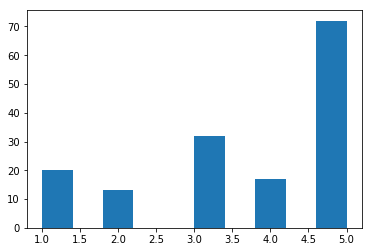

In [168]:
# discretise column 1
df_data = discretise_data(df_data, 20, 1, 3)
plot_hist_column(1, df_data)

In [169]:
assess_model(df_data)

0.82470588235294107

count    154.000000
mean       1.409740
std        1.196442
min        0.300000
25%        0.700000
50%        1.000000
75%        1.500000
max        8.000000
Name: 14, dtype: float64


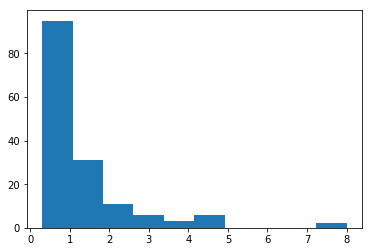

In [170]:
plot_hist_column(14, df_data)

In [171]:
# discretise column 14 which doesn't help
# df_data = discretise_data(df_data, 20, 14, 4)
# plot_hist_column(14, df_data)

In [172]:
assess_model(df_data)

0.82470588235294107

count    154.000000
mean     106.337662
std       50.153388
min       26.000000
25%       75.250000
50%       85.000000
75%      134.500000
max      295.000000
Name: 15, dtype: float64


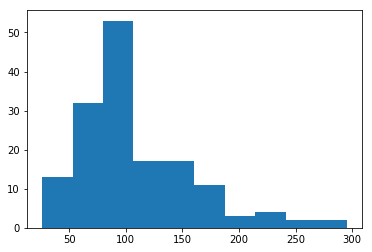

In [173]:
plot_hist_column(15, df_data)

In [174]:
# discretise column 15 which doesn't help
# df_data = discretise_data(df_data, 20, 15, 3)
# plot_hist_column(15, df_data)

In [175]:
# df_data = df_data_backup
assess_model(df_data)

0.82470588235294107

count    154.000000
mean      84.705091
std       89.828708
min      -83.285883
25%       31.250000
50%       58.000000
75%       99.500000
max      648.000000
Name: 16, dtype: float64


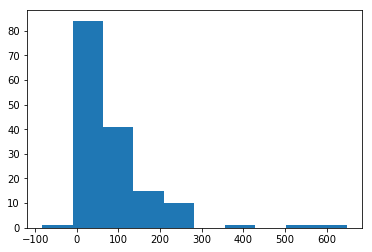

In [176]:
plot_hist_column(16, df_data)

net entropy:0.722405, data entropy:0.737241
current point:-48.462745, current info gain:0.014837
net entropy:0.722405, data entropy:0.737241
current point:-13.639608, current info gain:0.014837
net entropy:0.737237, data entropy:0.737241
current point:21.183529, current info gain:0.000005
net entropy:0.732274, data entropy:0.737241
current point:56.006666, current info gain:0.004968
net entropy:0.734200, data entropy:0.737241
current point:90.829804, current info gain:0.003041
net entropy:0.736565, data entropy:0.737241
current point:125.652941, current info gain:0.000677
net entropy:0.737122, data entropy:0.737241
current point:160.476078, current info gain:0.000119
net entropy:0.737223, data entropy:0.737241
current point:195.299215, current info gain:0.000018
net entropy:0.734866, data entropy:0.737241
current point:230.122353, current info gain:0.002376
net entropy:0.736925, data entropy:0.737241
current point:264.945490, current info gain:0.000316
net entropy:0.736020, data entrop

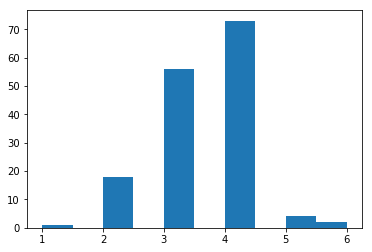

In [177]:
# discretise column 16
df_data = discretise_data(df_data, 20, 16, 4)
plot_hist_column(16, df_data)

In [178]:
assess_model(df_data)

0.83058823529411752

count    154.000000
mean       3.829947
std        0.623770
min        2.100000
25%        3.500000
50%        4.000000
75%        4.200000
max        6.400000
Name: 17, dtype: float64


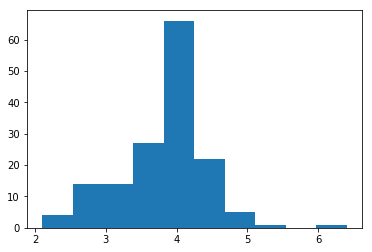

In [179]:
plot_hist_column(17, df_data)

In [180]:
# discretise column 17 which doesn't help
# df_data = discretise_data(df_data, 20, 17, 4)
# plot_hist_column(17, df_data)

In [181]:
# df_data = df_data_backup
assess_model(df_data)

0.83058823529411752

count    154.000000
mean      62.040729
std       21.367666
min        0.000000
25%       47.346517
50%       63.369028
75%       76.330870
max      110.599083
Name: 18, dtype: float64


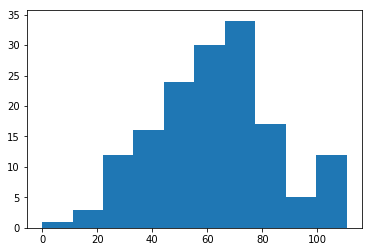

In [182]:
plot_hist_column(18, df_data)

In [183]:
# discretise column 18 which doesn't help
# df_data = discretise_data(df_data, 20, 18, 4)
# plot_hist_column(18, df_data)

In [184]:
# df_data = df_data_backup
df_data.to_csv(path_or_buf='hepatitis_dz.data', header=df_data_header, index=False)
assess_model(df_data)

0.83058823529411752

## apply decision tree after discretisation

In [185]:
df_data.columns = df_data_header
df_data.head()

Class  AGE  SEX STEROID  ANTIVIRALS FATIGUE MALAISE ANOREXIA LIVERBIG  \
0      2    2    2       1           2       2       2        2        1   
1      2    5    1       1           2       1       2        2        1   
2      2    5    1       2           2       1       2        2        2   
3      2    3    1       1           1       2       2        2        2   
4      2    3    1       2           2       2       2        2        2   

  LIVERFIRM SPLEENPALPABLE SPIDERS ASCITES VARICES  BILIRUBIN  ALKPHOSPHATE  \
0         2              2       2       2       2        1.0          85.0   
1         2              2       2       2       2        0.9         135.0   
2         2              2       2       2       2        0.7          96.0   
3         2              2       2       2       2        0.7          46.0   
4         2              2       2       2       2        1.0         181.0   

   SGOT  ALBUMIN    PROTIME  HISTOLOGY  
0   2.0      4.0  66.703742          1  
1   3.0      3.5  56.995963          1  
2   3.0      4.0  63.466653          1  
3   3.0      4.0  80.000000          1  
4   4.0      4.0  66.277647          1

In [194]:
clf = tree.DecisionTreeClassifier(random_state=0)

dt_X = df_data.drop('Class', axis=1)
dt_y = df_data.loc[:, 'Class']
dt_train_X, dt_test_X, dt_train_y, dt_test_y = train_test_split(dt_X, dt_y, test_size=0.1, random_state=42)
print(dt_train_X.shape)
print(dt_test_X.shape)
clf.fit(dt_train_X, dt_train_y)
training_accuracy = clf.score(dt_train_X, dt_train_y)
test_accuracy = clf.score(dt_test_X, dt_test_y)
print(training_accuracy, test_accuracy)
# cv_results = cross_val_score(clf, dt_train_X, dt_train_y, cv=10)
# print(cv_results)
# np.mean(cv_results)

(138, 19)
(16, 19)
1.0 0.8125


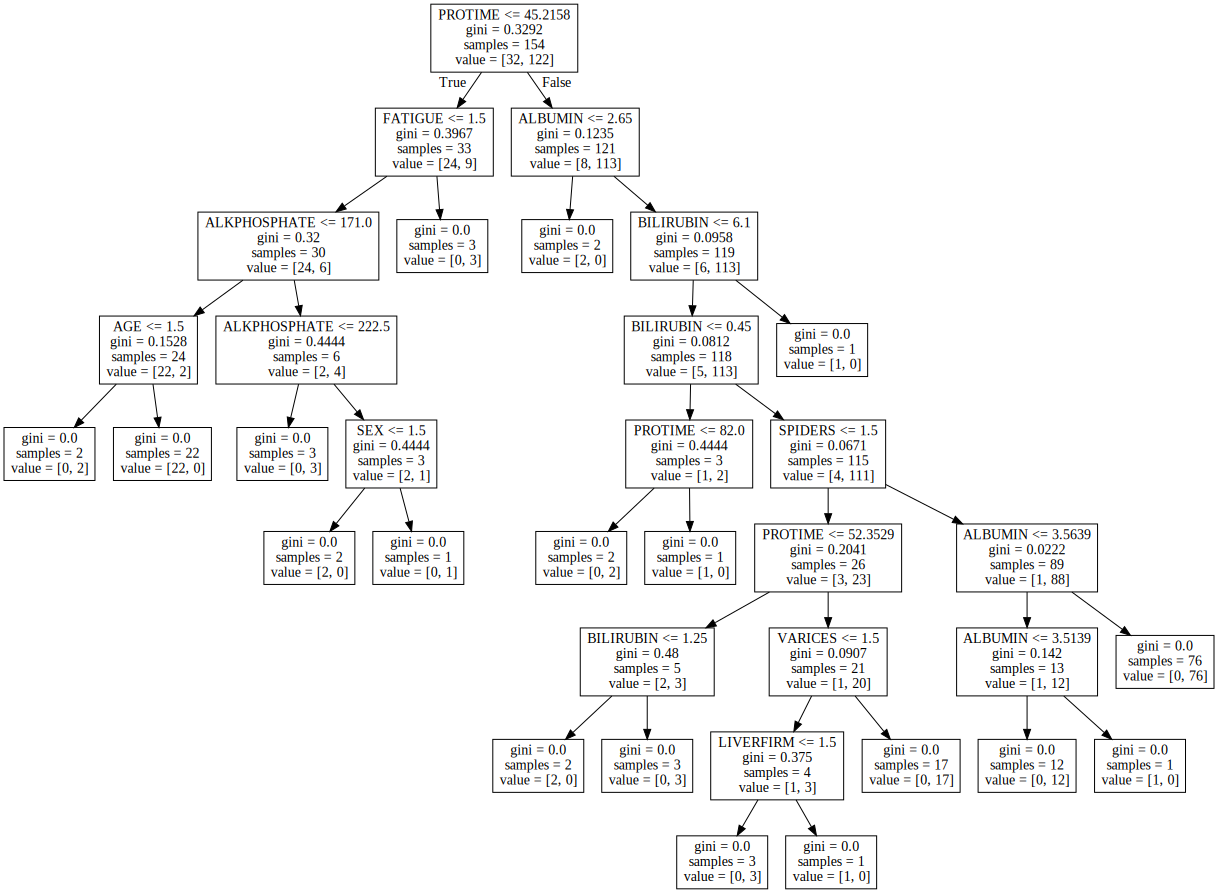

In [187]:
tree.export_graphviz(clf, out_file='dp_tree.dot', feature_names=dt_train_X.columns.values) 
dot_data = tree.export_graphviz(clf, out_file=None, feature_names=dt_train_X.columns.values) 
graph = graphviz.Source(dot_data) 
graph